In [30]:
%matplotlib inline

import numpy as np
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from warnings import filterwarnings
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import mean_absolute_percentage_error as mape
from tqdm import tqdm
from typing import List, Optional
import glob

from facemesh import FaceMeshBlock, FaceMesh
from pupil_detection import IrisLM, IrisBlock
from util_funcs import pad_image
from face_detector import FaceDetector

filterwarnings('ignore')
tqdm.pandas()

In [2]:
torch.cuda.is_available()

True

### Dataset

In [3]:
class EyesExtractor:
    def __init__(
        self,
        save_folder: Optional[str] = None,
        facemesh_weights: str = "./weights/facemesh.pth",
        device: str = "cpu"
    ):
        self.facemesh =  FaceMesh().to(device)
        self.facemesh.load_weights(facemesh_weights)
        self.left_eye_indices = [33, 7, 163, 144, 145, 153, 154, 155,
                                 246, 161, 160, 159, 158, 157, 173, 133]
        self.right_eye_indices = [249, 263, 362, 373, 374, 380, 381, 382,
                                  384, 385, 386, 387, 388, 390, 398, 466]

    def get_eye_crop(self, points: np.array, img: np.array, which_eye: str):
        h, w, _ = img.shape
        sorted_point_x = sorted(points, key = lambda x: x[0])
        sorted_point_y = sorted(points, key = lambda x: x[1])
        left_point = sorted_point_x[0]
        right_point = sorted_point_x[-1]
        up_point = sorted_point_y[0]
        down_point = sorted_point_y[-1]
        multiplicator = 1/2
        margin_x_left = max(64 - (right_point[0] - left_point[0]), 0) * multiplicator
        margin_x_right = max(64 - (right_point[0] - left_point[0]), 0) * (1 - multiplicator)
        margin_y = max(64 - (down_point[1] - up_point[1]), 0) / 2
        min_x, max_x = max(0, int(left_point[0] - margin_x_left)), min(w, int(right_point[0] + margin_x_right))
        min_y, max_y = max(0, int(up_point[1] - margin_y)), min(h, int(down_point[1] + margin_y))
        img_eye = img[min_y: max_y, min_x: max_x, :]
        left_top_point = (min_x, min_y) 
        return img_eye, left_top_point


    def extract_eyes(self, face_crop: np.ndarray):
        face_crop = cv2.resize(face_crop, (192, 192), interpolation = cv2.INTER_LINEAR)
        face_crop = cv2.flip(face_crop, 1)
        facemesh_points = self.facemesh.predict_on_image(face_crop).cpu().numpy()
        left_eye_points = facemesh_points[self.left_eye_indices]
        right_eye_points = facemesh_points[self.right_eye_indices]
        img_eye_left, _ = self.get_eye_crop(left_eye_points, face_crop, which_eye = "left")
        img_eye_right, _ = self.get_eye_crop(right_eye_points, face_crop, which_eye = "right")
        return img_eye_left, img_eye_right

In [4]:
class GazeDetectionDataset(Dataset):
    """Gaze detection dataset."""

    def __init__(
        self,
        data: pd.DataFrame,
        transform_list: Optional[List]= None,
        to_tensors: bool = False,
        device: str = "cpu",
        inference: bool = False,
        screen_features: bool = False,
        precompute_folder: str = "./data_precompute"
    ):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = data.copy()
        self.to_tensors = to_tensors
        transform_list_ = transform_list.copy()
        if to_tensors:
            transform_list_.append(ToTensorV2())
        transform_list_eyes = []
        if to_tensors:
            transform_list_eyes.append(ToTensorV2())
        self.transform = A.Compose(transform_list_)
        self.transform_eyes = A.Compose(transform_list_eyes)
        transform_list_mask = [A.Resize(25, 25)]
        if to_tensors:
            transform_list_mask.append(ToTensorV2())
        self.transform_mask = A.Compose(transform_list_mask)
        self.device = torch.device(device)
        self.faceCascade = cv2.CascadeClassifier("./weights/haarcascade_frontalface_alt.xml")
        self.eyesExtractor = EyesExtractor(device = device)
        self.inference = inference
        if device != "cpu":
            device = str(0)
        self.face_detector = FaceDetector(device = device)
        self.screen_features = screen_features
        self.precompute_folder = precompute_folder
        if not os.path.exists(precompute_folder):
            os.mkdir(precompute_folder)
            os.mkdir(os.path.join(precompute_folder, "faces"))
            os.mkdir(os.path.join(precompute_folder, "eyes"))
            os.mkdir(os.path.join(precompute_folder, "bboxes"))


    def get_face_mask(self, frame, face_rect):
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        if face_rect is None:
            return mask
        mask[
            face_rect[1] : face_rect[1] + face_rect[3],
            face_rect[0] : face_rect[0] + face_rect[2]
        ] = 1
        return mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        img_path = row['paths']
        try:
            image_orig = cv2.imread(img_path)
            image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
            img_path_ = Path(img_path)
            face_path = os.path.join(self.precompute_folder, "faces", img_path_.name)
            face_rect_path = face_path.replace("faces", "bboxes").replace(".png", ".npy")
            image, face_rect = self.face_detector.detect_face(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            face_mask = self.get_face_mask(image_orig, face_rect)
            eyes_path_l = face_path.replace("faces", "eyes").replace(".png", "_left.png")
            eyes_path_r = face_path.replace("faces", "eyes").replace(".png", "_right.png")
            image_eye_l, image_eye_r = self.eyesExtractor.extract_eyes(image)
            image_eye_l_ = cv2.cvtColor(image_eye_l, cv2.COLOR_RGB2BGR)
            image_eye_r_ = cv2.cvtColor(image_eye_r, cv2.COLOR_RGB2BGR)
            image = image / 255.
            image_eye_l = image_eye_l / 255.
            image_eye_r = image_eye_r / 255.
        except Exception:
            raise Exception(f"Image {img_path}, {eye_left_path} failed loading")
        if not self.inference:
            coordinates = row[['x_normalized', 'y_normalized']].values.astype(np.float32)
        if self.screen_features:
            screen_feat = row[[
                'Screen Width (cm)',
                'Screen Height (cm)',
                'Distance From Screen (cm)'
            ]].values.astype(np.float32)
            screen_feat = (screen_feat - screen_feat.mean()) / screen_feat.std()
        
        if self.transform:
            image = self.transform(image = image)['image']
            face_mask = self.transform_mask(image = face_mask)['image']
            image_eye_l = self.transform_eyes(image = image_eye_l)['image']
            image_eye_r = self.transform_eyes(image = image_eye_r)['image']
            if self.to_tensors:
                if not self.inference:
                    coordinates = torch.from_numpy(coordinates).to(self.device)
                if self.screen_features:
                    screen_feat = torch.from_numpy(screen_feat).to(self.device)
                image = image.type(torch.float32).to(self.device)
                image_eye_l = image_eye_l.type(torch.float32).to(self.device)
                image_eye_r = image_eye_r.type(torch.float32).to(self.device)
                face_mask = face_mask.type(torch.float32).to(self.device)
            
        sample = {'image': image, "eye_l": image_eye_l,
                  "eye_r": image_eye_r, "face_mask": face_mask}
        if not self.inference:
            sample['coordinates'] = coordinates
        if self.screen_features:
            sample['screen_features'] = screen_feat
        return sample

#### Extract frames

In [43]:
from pathlib import Path
from video2images import Video2Images

In [44]:
out_folder = "./test_frames_6_/"

In [45]:
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [47]:
Video2Images(video_filepath="./test_6_2.mov",
             save_format=".png",
             out_dir=out_folder)

 Video Duration is 0hr: 0min: 29sec 
 The input Video FPS is 30 frames/sec
 Capture rate is default FPS of input video i.e 30 frames/sec


 Capturing Frames... :  99%|███████████████▉| 895/900 [03:39<00:01,  4.09iter/s]

 Done. Total frames captured: 895 


In [64]:
res = !ls $out_folder

In [65]:
tmp_dir =  f"{out_folder}/{res[0]}/"

In [66]:
filenames = os.listdir(tmp_dir)

In [67]:
for filename in filenames:
    os.rename(os.path.join(tmp_dir, filename), os.path.join(out_folder, filename))

In [68]:
tmp_dir

'./test_frames_6_//frames_folder_2023-10-09 10:03:25/'

In [69]:
!rm -r './test_frames_6_/frames_folder_2023-10-09 10:03:25/'

In [70]:
p = Path(out_folder).glob('*.png')

In [71]:
paths = [str(path.absolute()) for path in p]

In [72]:
df_files = pd.DataFrame({"paths": paths})
df_files["ind"] = df_files.paths.apply(lambda x: int(Path(x).stem))
df_files = df_files.sort_values("ind").set_index("ind")

In [74]:
df_files["paths"].iloc[0]

'/home/ubuntu/projects/tweakle/gaze_detection/test_frames_6_/1.png'

In [75]:
df_files.shape

(895, 1)

In [76]:
df_files.head(3)

,paths
ind,
1,/home/ubuntu/projects/tweakle/gaze_detection/t...
2,/home/ubuntu/projects/tweakle/gaze_detection/t...
3,/home/ubuntu/projects/tweakle/gaze_detection/t...


In [77]:
# with open("./closed_eyes.txt", "r") as f:
#     st = f.read().strip(" \n")

In [78]:
# img_noeyes = st.split("\n")

In [79]:
# df_files["closed_eyes"] = df_files["paths"].apply(lambda x: x not in [str(Path(x).absolute()) for x in img_noeyes])

In [80]:
# not_closed_eyes = df_files["closed_eyes"].values

In [81]:
# width_screen_cm, height_screen_cm, distance_screen_cm = 28.5, 18., 60.

In [82]:
# df_files['Screen Width (cm)'] = [28.5] * df_files.shape[0]
# df_files['Screen Height (cm)'] = [18.] * df_files.shape[0]
# df_files['Distance From Screen (cm)'] = [60.] * df_files.shape[0]

In [83]:
trans_list = [
        A.Resize(192, 192),
        # ToTensorV2()
    ]

In [84]:
# data = pd.read_csv("./tobii_train_sub_updv2.csv")

Fusing layers... 
0 (192, 192, 3)


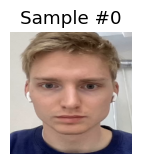

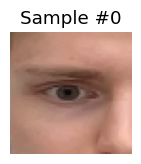

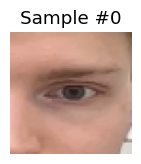

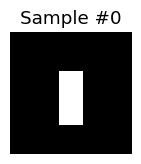

1 (192, 192, 3)


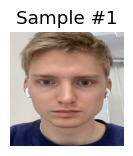

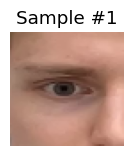

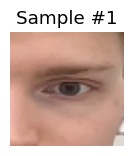

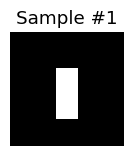

2 (192, 192, 3)


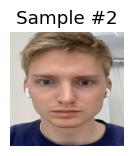

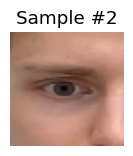

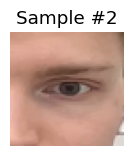

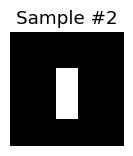

3 (192, 192, 3)


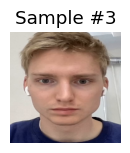

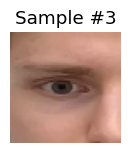

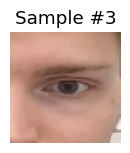

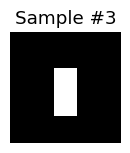

In [85]:
face_dataset = GazeDetectionDataset(data=df_files, transform_list=trans_list, inference=True, screen_features=False)

fig = plt.figure()

for i, sample in enumerate(face_dataset):
    print(i, sample['image'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(np.array(sample['image']))
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_l'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['eye_r'])
    plt.show()
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    ax.imshow(sample['face_mask'], cmap = "gray")
    plt.show()
    if i == 3:
        plt.show()
        break

In [86]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [17]:
face_dataset = GazeDetectionDataset(data = df_files, transform_list=trans_list,
                                    to_tensors=True, device=device, inference=True, screen_features=False))

Fusing layers... 


In [32]:
for i, sample in enumerate(face_dataset):
    print(i, sample['image'].size(), sample['eye_l'].size(), sample['face_mask'].size())
    if i == 3:
        break

0 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
1 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
2 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])
3 torch.Size([3, 192, 192]) torch.Size([3, 64, 64]) torch.Size([1, 25, 25])


### Model

In [87]:
pretrained_model_face = FaceMesh()
pretrained_model_face.load_weights("./weights/facemesh.pth")

model_path = "./weights/irislandmarks.pth"
pretrained_model_eyes = IrisLM()
weights = torch.load(model_path)
pretrained_model_eyes.load_state_dict(weights)

<All keys matched successfully>

In [88]:
class FaceGridModel(nn.Module):
    def __init__(self, gridSize = 25):
        super(FaceGridModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(gridSize * gridSize, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [89]:
class EyesModel(nn.Module):
    def __init__(self, pretrained_model_eyes: nn.Module):
        super(EyesModel, self).__init__()
        self.backbone = pretrained_model_eyes.backbone
        self.regression_head_eyes = nn.Sequential(
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
            IrisBlock(128, 128, stride=2),
            IrisBlock(128, 128), IrisBlock(128, 128),
        )
        # connect eyes
        self.fc = nn.Sequential(
            nn.Linear(2 * 128 * 1 * 1, 128),
            nn.ReLU(inplace=True),
        )

    def forward(self, x_eye_l, x_eye_r):
        x_eye_l = self.backbone(x_eye_l)
        x_eye_l = self.regression_head_eyes(x_eye_l)
        x_eye_l = x_eye_l.view(-1, 128 * 1 * 1)

        x_eye_r = self.backbone(x_eye_r)
        x_eye_r = self.regression_head_eyes(x_eye_r)
        x_eye_r = x_eye_r.view(-1, 128 * 1 * 1)
        x = torch.cat([x_eye_l, x_eye_r], 1)
        x = self.fc(x)
        return x

In [90]:
class FaceModel(nn.Module):
    def __init__(self, pretrained_model_face: nn.Module):
        super(FaceModel, self).__init__()
        self.backbone = pretrained_model_face.backbone
        self.regression_head_face = nn.Sequential(
            FaceMeshBlock(128, 128, stride=2),
            FaceMeshBlock(128, 128),
            FaceMeshBlock(128, 128),
            nn.Conv2d(128, 32, 1),
            nn.PReLU(32),
            FaceMeshBlock(32, 32),
        )
        self.fc = nn.Sequential(
            nn.Linear(32 * 3 * 3, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
        )

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0

    def forward(self, x_face):
        x_face = self._preprocess(x_face)
        x_face = nn.ReflectionPad2d((1, 0, 1, 0))(x_face)
        x_face = self.backbone(x_face)
        x_face = self.regression_head_face(x_face)
        x_face = x_face.view(-1, 32 * 3 * 3)
        x = self.fc(x_face)
        return x

In [91]:
class FineTuneModel(nn.Module):
    def __init__(
        self,
        pretrained_model_face: nn.Module,
        pretrained_model_eyes: nn.Module,
        screen_features: bool = False,
    ):
        super(FineTuneModel, self).__init__()
        self.face_model = FaceModel(pretrained_model_face)
        self.eyes_model = EyesModel(pretrained_model_eyes)
        self.face_grid_model = FaceGridModel()
        self.screen_features = screen_features
        if not screen_features:
            self.fc = nn.Sequential(
                nn.Linear(128+64+128, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2),
            )
        else:
            self.fc1 = nn.Sequential(
                nn.Linear(128+64+128, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 13),
                nn.ReLU(inplace=True),
            )
            self.layer_norm = nn.LayerNorm(16)
            self.fc2 = nn.Linear(16, 2)
            

    def _preprocess(self, x):
        return x.to(torch.float32) * 2.0 - 1.0
        
    def forward(self, x_face, x_eye_l, x_eye_r, x_grid, x_screen = None):
        if self.screen_features and x_screen is None:
            raise Exception("You should pass screen features")
        if not self.screen_features and x_screen is not None:
            warnings.warn("Screen fearures won't be used")
        x_eyes = self.eyes_model(x_eye_l, x_eye_r)
        x_face = self.face_model(x_face)
        x_grid = self.face_grid_model(x_grid)
        x = torch.cat([x_eyes, x_face, x_grid], axis = 1)
        if not self.screen_features:
            x = self.fc(x)
        else:
            x = self.fc1(x)
            x = torch.cat([x, x_screen], axis = 1)
            x = self.layer_norm(x)
            x = self.fc2(x)
        return x

In [92]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes, screen_features=False).to(device)

In [93]:
screen_feat = np.array([[33.17, 20.73, 54.0], [33.17, 20.73, 54.0]])
screen_feat = torch.tensor((screen_feat - screen_feat.mean()) / screen_feat.std()).type(torch.float32).to(device)
screen_feat

tensor([[-0.20376, -1.11009,  1.31384],
        [-0.20376, -1.11009,  1.31384]], device='cuda:0')

In [94]:
rand_img = np.random.randint(0, 255, (2, 3, 192,192))
x_face = torch.from_numpy(rand_img).to(device)
rand_img = (np.random.randint(0, 255, (2, 3, 64, 64)) / 255.)
x_eye = torch.from_numpy(rand_img).type(torch.float32).to(device)
rand_grid = (np.random.randint(0, 255, (2, 25, 25)) / 255.)
x_grid = torch.from_numpy(rand_grid).type(torch.float32).to(device)

In [95]:
model(x_face, x_eye, x_eye, x_grid)

tensor([[-0.19915,  0.17761],
        [-0.19928,  0.04184]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [96]:
CHECKPOINTS_PATH = "./checkpoints"
EXPERIMENT_NAME = "face_eyes_mask_correctedv2_balanced_tune"

In [97]:
model = FineTuneModel(pretrained_model_face, pretrained_model_eyes, screen_features=False).to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_PATH, f"best_{EXPERIMENT_NAME}.pt")))
model.eval()

FineTuneModel(
  (face_model): FaceModel(
    (backbone): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): PReLU(num_parameters=16)
      (2): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (3): FaceMeshBlock(
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16)
          (1): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (act): PReLU(num_parameters=16)
      )
      (4): FaceMeshBlock(
        (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (convs): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), groups=16)
          (1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
   

In [98]:
def inference(model: FineTuneModel, dataloader_eval: DataLoader):
    model.eval()
    preds_list = []
    for i, data in tqdm(enumerate(dataloader_eval), total = len(dataloader_test)):
        inputs, inputs_eye_l, inputs_eye_r, inputs_mask = data['image'], \
                                                     data['eye_l'], data['eye_r'], data['face_mask']
        with torch.no_grad():
            outputs = model(inputs, inputs_eye_l, inputs_eye_r, inputs_mask)
        preds_list += outputs.cpu().detach().tolist()
        
    return preds_list

In [99]:
dataset_test = GazeDetectionDataset(data = df_files, transform_list=trans_list,
                                    to_tensors=True, device=device, inference=True, screen_features=False)
dataloader_test = DataLoader(dataset_test, batch_size=1,
                        shuffle=False)

Fusing layers... 


In [100]:
preds = inference(model, dataloader_test)

100%|█████████████████████████████████████████| 895/895 [01:22<00:00, 10.88it/s]


In [101]:
np.save("./test_preds_misha_test.npy", preds)

In [102]:
x, y = np.array(preds).T

In [103]:
len(x)

895

In [104]:
import pickle
calib_model = pickle.load(open('calibr_model_misha.pckl', 'rb'))

In [105]:
preds_rescaled = calib_model.predict(preds)

In [106]:
x_rescaled, y_rescaled = np.array(preds_rescaled).T

In [107]:
# x = x[not_closed_eyes]
# y = y[not_closed_eyes]

In [108]:
# scale_ratio_x  = 51.70 / width_screen_cm
# scale_ratio_y  = 32.31 / height_screen_cm

In [109]:
# width_screen_px, height_screen_px = 304, 212

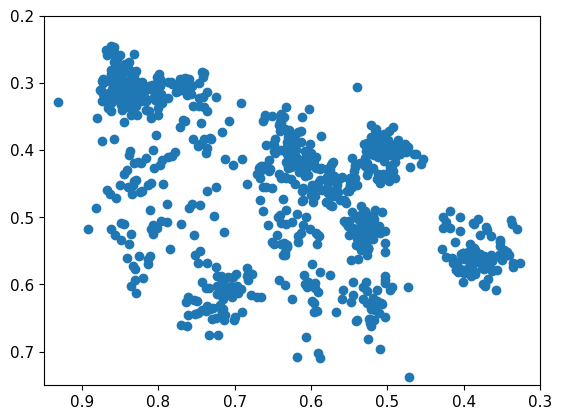

In [113]:
plt.scatter(x, y)
plt.ylim(0.75, 0.2)
plt.xlim(0.95, 0.3)
plt.show()

In [40]:
# min_y = min(y[2*30:10*30])
# min_x = min(x[2*30:4*30])
# max_y = max(y[12*30:19*30])
# max_x = max(x[11*30:13*30])

In [41]:
# min_y

In [42]:
# x_rescaled = np.clip(x, 0.2, 1.1)
# y_rescaled = np.clip(y, 0.15, 0.45)

In [43]:
# min_y = min(y_rescaled)
# min_x = min(x_rescaled)
# max_y = max(y_rescaled)
# max_x = max(x_rescaled)

In [44]:
# x_rescaled = x * scale_ratio_x
# y_rescaled = y * scale_ratio_y

In [45]:
# min_x

In [46]:
# x_rescaled = (x_rescaled - 0.4) / (max_x - min_x - 0.2)
# y_rescaled = (y_rescaled - min_y) / (max_y - min_y)

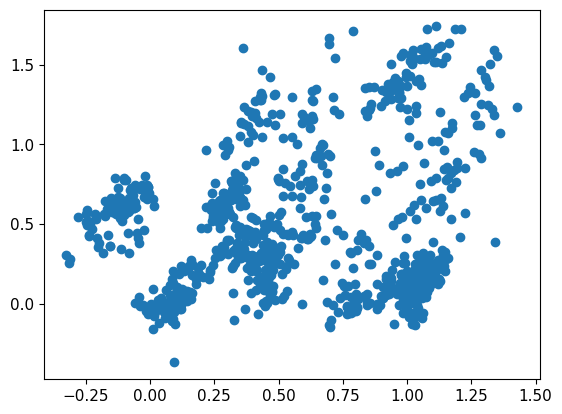

In [114]:
plt.scatter(x_rescaled, y_rescaled)
# plt.ylim(1, 0)
# plt.xlim(-0.25, 1)
plt.show()

In [118]:
x_rescaled_ = np.clip(x_rescaled, 0, 1)
y_rescaled_ = np.clip(y_rescaled, 0, 1)

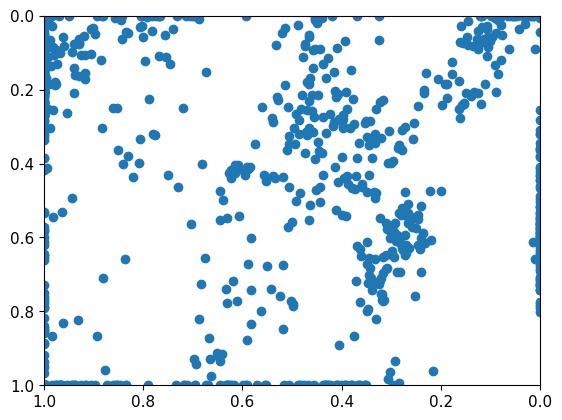

In [120]:
plt.scatter(x_rescaled_, y_rescaled_)
plt.ylim(1, 0)
plt.xlim(1, 0)
plt.show()

In [121]:
res_folder = "./test_results"

In [122]:
!rm -r $res_folder

In [123]:
!mkdir $res_folder

In [124]:
for i in tqdm(range(len(x))):
    fig = plt.figure()
    fig.patch.set_visible(False)
    plt.scatter([x_rescaled_[i]], [y_rescaled_[i]])
    plt.ylim(1, 0)
    plt.xlim(1, 0)
    plt.savefig(f"{res_folder}/{i}.png")
    plt.close(fig)

100%|█████████████████████████████████████████| 895/895 [01:44<00:00,  8.54it/s]


In [125]:
filenames = sorted(glob.glob(f"{res_folder}/*.png"), key = lambda x: int(Path(x).stem))

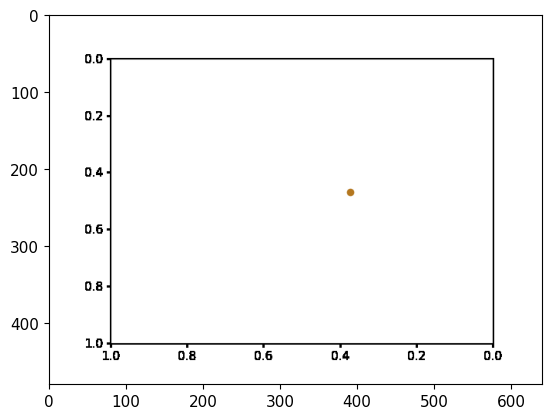

In [126]:
img = cv2.imread(filenames[0])
plt.imshow(img)

In [127]:
h, w, _ = img.shape

In [128]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
fps = 30
video = cv2.VideoWriter('gaze_misha_test.mp4', fourcc, fps, (w, h))
for filename in tqdm(filenames):
    img = cv2.imread(filename)
    video.write(img)

cv2.destroyAllWindows()
video.release()

100%|████████████████████████████████████████| 895/895 [00:05<00:00, 167.27it/s]
